In [1]:
#pip install pmdarima==2.0.2 keras pip tensorflow lightgbm

In [2]:
from __future__ import division
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
df_merged=pd.read_csv("df_ML.csv")

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_m=df_merged[['Subjectivity','Positive','Polarity','Compound','Adj Close','Adj Close Detrended']]
df = pd.DataFrame(scaler.fit_transform(df_m))
df.columns = df_m.columns
df.index = df_m.index
df.head()

,Subjectivity,Positive,Polarity,Compound,Adj Close,Adj Close Detrended
0,0.612886,0.437086,0.185828,0.122171,0.460175,0.536526
1,0.668332,0.238411,0.582998,0.014199,0.523735,0.658698
2,0.529835,0.238411,0.495499,0.053986,0.524923,0.636589
3,0.425388,0.543046,0.194716,0.944759,0.515995,0.592058
4,0.616857,0.397351,0.364683,0.130249,0.474178,0.472375


## SARIMAX Model

                                SARIMAX Results                                
Dep. Variable:     Adj Close Detrended   No. Observations:                  175
Model:                  ARIMA(1, 0, 1)   Log Likelihood                 113.300
Date:                 Sat, 22 Apr 2023   AIC                           -216.600
Time:                         16:58:46   BIC                           -200.776
Sample:                              0   HQIC                          -210.181
                                 - 175                                         
Covariance Type:                   opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4520      0.037     12.100      0.000       0.379       0.525
Subjectivity     0.0066      0.056      0.116      0.907      -0.104       0.117
ar.L1            0.5470      0.090  

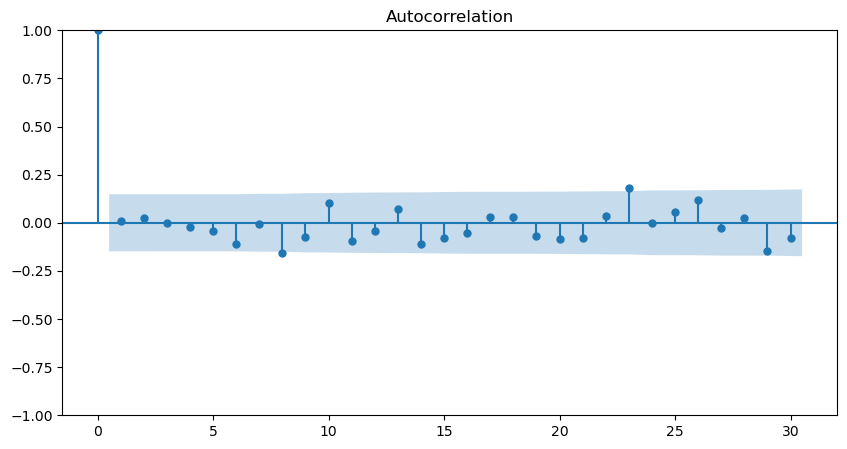

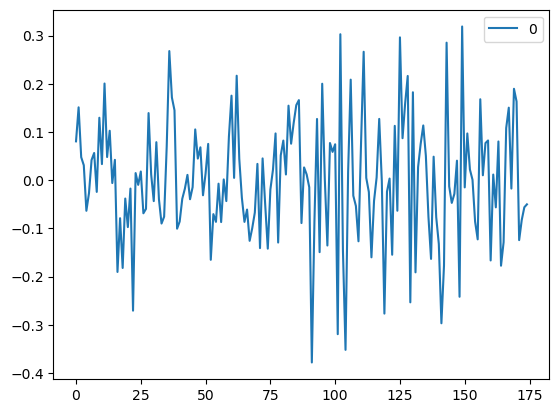

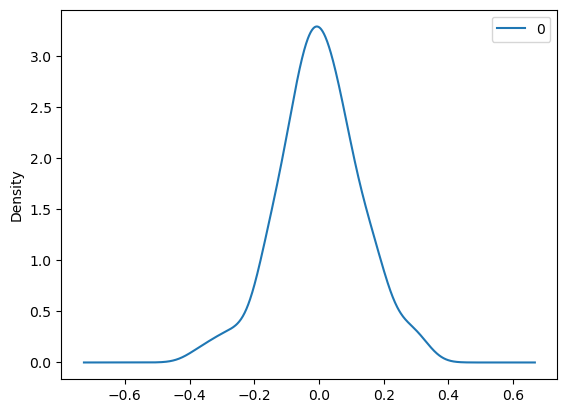

In [5]:
ts_data = pd.concat([df['Subjectivity'], df['Adj Close Detrended']], axis=1)

# split data into training and test sets
train_size = int(len(ts_data) * 0.7)
train, test = ts_data[0:train_size], ts_data[train_size:]

# define ARIMA model and fit to training data
p, d, q = 1, 0, 1
model = sm.tsa.ARIMA(endog=train['Adj Close Detrended'], exog=train['Subjectivity'], order=(p, d, q))
results = model.fit()

# print model summary
print(results.summary())

# plot autocorrelation of residuals
fig, ax = plt.subplots(figsize=(10, 5))
sm.graphics.tsa.plot_acf(results.resid, ax=ax, lags=30)
plt.show()

# plot residuals and density
residuals = pd.DataFrame(results.resid)
residuals.plot()
residuals.plot(kind='kde')
plt.show()

In [6]:
from sklearn.metrics import mean_squared_error
exog_test = test['Subjectivity']
y_pred = results.predict(start=len(train), end=len(train)+len(test)-1, exog=exog_test)

# compute RMSE
rmse = np.sqrt(mean_squared_error(test['Adj Close Detrended'], y_pred))
mse = mean_squared_error(test['Adj Close Detrended'], y_pred)
print('Test MSE:', mse)
print('Test RMSE:', rmse)

from sklearn.metrics import mean_absolute_error

# obtain the actual and predicted values
y_actual = test['Adj Close Detrended']
y_pred = results.predict(start=len(train), end=len(train)+len(test)-1, exog=exog_test)

# calculate MAE value
mae = mean_absolute_error(y_actual, y_pred)

print('MAE value: {:.2f}'.format(mae))


Test MSE: 0.026488560162741634
Test RMSE: 0.16275306498724265
MAE value: 0.13


## Random Forest

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and testing sets
train_size = int(len(df_merged) * 0.7)
train_set = df[:train_size]
test_set = df[train_size:]

# Define the features and target variables
X_train = train_set[['Subjectivity']]
y_train = train_set[['Adj Close Detrended']]

X_test = test_set[['Subjectivity']]
y_test = test_set['Adj Close Detrended']

# Create a random forest regressor object
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the random forest regressor
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Calculate the mean squared error and R-squared value
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('MAE value: {:.2f}'.format(mae))

Mean Squared Error: 0.032726808633446174
Root Mean Squared Error: 0.18090552405453564
MAE value: 0.14


C:\Users\JaceS\AppData\Local\Temp\ipykernel_16868\3866669505.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regressor.fit(X_train, y_train)


## XGBoost

In [8]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and testing sets
train_size = int(len(df_merged) * 0.7)
train_set = df[:train_size]
test_set = df[train_size:]

# Define the features and target variables
X_train = train_set[['Subjectivity']]
y_train = train_set['Adj Close Detrended']

X_test = test_set[['Subjectivity']]
y_test = test_set['Adj Close Detrended']

# Create an XGBoost regressor object
xgb_regressor = XGBRegressor(n_estimators=100, random_state=42)

# Train the XGBoost regressor
xgb_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_regressor.predict(X_test)

# Calculate the mean squared error and R-squared value
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('MAE value: {:.2f}'.format(mae))

Mean Squared Error: 0.0418847380650055
Root Mean Squared Error: 0.20465761179346714
MAE value: 0.16


## LightGBM

In [9]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and testing sets
train_size = int(len(df_merged) * 0.7)
train_set = df[:train_size]
test_set = df[train_size:]

# Define the features and target variables
X_train = train_set[['Subjectivity']]
y_train = train_set['Adj Close Detrended']

X_test = test_set[['Subjectivity']]
y_test = test_set['Adj Close Detrended']

# Create a LGBM regressor object
lgbm_regressor = LGBMRegressor(n_estimators=100, random_state=42)

# Train the LGBM regressor
lgbm_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lgbm_regressor.predict(X_test)

# Save the predicted values to a CSV file
predictions_df = pd.DataFrame({'predicted_values': y_pred})
predictions_df.to_csv('predicted_values.csv', index=False)

# Calculate the mean squared error and R-squared value
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('MAE value: {:.2f}'.format(mae))


Mean Squared Error: 0.030461689440413876
Root Mean Squared Error: 0.17453277468834866
MAE value: 0.14


## LSTM

In [10]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

175/175 [==============================] - 2s 1ms/step - loss: 0.0453


In [11]:
from keras.layers import Flatten

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


# Create a new dataframe with only the 'Subjectivity' and 'Adj Close' columns
data = df.filter(['Subjectivity', 'Adj Close'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * 0.7 ))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set
train_data = scaled_data[0:training_data_len, :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []
n_steps = 60 # the number of time steps to include in each input sequence
for i in range(n_steps, len(train_data)):
    x_train.append(train_data[i-n_steps:i, :])
    y_train.append(train_data[i, 1])
x_train, y_train = np.array(x_train), np.array(y_train)

# Create the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Create the testing data set
test_data = scaled_data[training_data_len-n_steps:, :]

# Split the data into x_test and y_test data sets
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(n_steps, len(test_data)):
    x_test.append(test_data[i-n_steps:i, :])
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

# Make predictions
predictions = model.predict(x_test)

# Undo the scaling
#predictions = scaler.inverse_transform(predictions)
y_test = y_test.reshape(-1, 2)  # Reshape y_test to have shape (75,1)
print(y_test.shape)
y_test = scaler.inverse_transform(y_test)
print(y_test.shape)


# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print('RMSE:', rmse)

# Calculate the mean squared error (MSE)
mse = np.mean((predictions - y_test) ** 2)
print('MSE:', mse)


3/3 [==============================] - 0s 11ms/step
(75, 2)
(75, 2)
RMSE: 0.15358717175117675
MSE: 0.023589019326525466


C:\Users\JaceS\AppData\Local\Temp\ipykernel_16868\2848346960.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


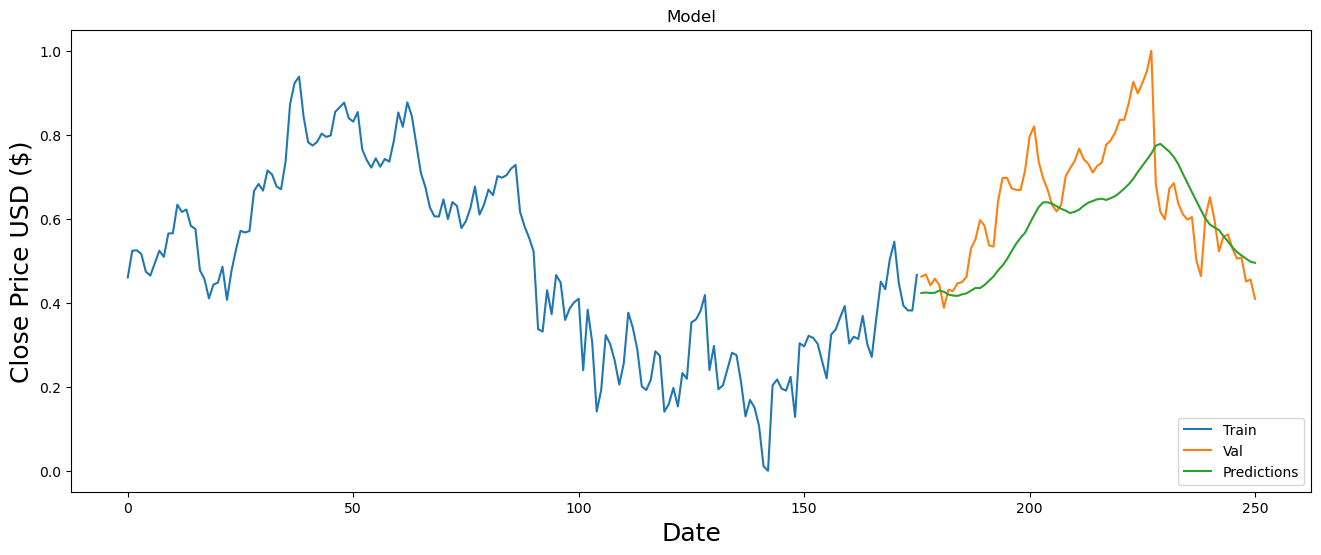

In [12]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()